In [2]:
import os
import subprocess
import csv
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.mixture import GMM 
from Kitsune import Kitsune

matplotlib_is_available = True
try:
    from matplotlib import pyplot as plt
except ImportError:
    print("Will skip plotting; matplotlib is not available.")
    matplotlib_is_available = False

# File location
path = "100000_packets_mirai.tsv" #the pcap, pcapng, or tsv file to process.
packet_limit = np.Inf #the number of packets to process

# KitNET params:
maxAE = 10 #maximum size for any autoencoder in the ensemble layer
FMgrace = 5000 #the number of instances taken to learn the feature mapping (the ensemble's architecture)
ADgrace = 50000 #the number of instances used to train the anomaly detector (ensemble itself)

# Build Kitsune
K = Kitsune(path,packet_limit,maxAE,FMgrace,ADgrace)

# Train Kitsune
print("Training Kitsune:")
RMSEs = []
i = 0
while True:
    i+=1
    if i % 1000 == 0:
        print(i)
    rmse, _ = K.proc_next_packet()
    if rmse == -1:
        break
    RMSEs.append(rmse)
    
threshold = max(RMSEs[0: 69999])
labels = []     
y_all_blackbox = list(range(0, FMgrace + ADgrace + 1))
for line in open("100000_labels_mirai.tsv"): 
    if line.find('0') != -1:
        labels.append(0)
    elif line.find('1') != -1:
        labels.append(1)
        
positive_sum = 30001
positive_num = 0
positive_train = int(positive_sum * 0.6)
train_num = 0
positive_test= positive_sum-positive_train
test_num = 0
num = 0
for i in range(FMgrace + ADgrace + 1, 100000):
    if labels[i] == 1:
        num += 1
        if RMSEs[i] > threshold: 
            positive_num += 1
            if num <= positive_train:
                train_num += 1
            else:
                test_num += 1
    if RMSEs[i] > threshold:
        y_all_blackbox.append(1)
    elif RMSEs[i] <= threshold:
        y_all_blackbox.append(0)
Original_TPR = positive_num / positive_sum
train_TPR = train_num / positive_train
test_TPR = test_num / positive_test
print('threshold: {0}'.format(threshold))
print('Original_TPR: {0}'.format(Original_TPR)) 
print('train_TPR: {0}, test_TPR: {1}'.format(train_TPR, test_TPR)) 

counting lines in file...
There are 100001 Packets.
Feature-Mapper: train-mode, Anomaly-Detector: off-mode
Training Kitsune:
1000
2000
3000
4000
5000
origional ids of the features
[[35]]
origional ids of the features
[[48, 20, 41, 27, 34]]
origional ids of the features
[[71, 78, 85, 92, 99]]
origional ids of the features
[[21, 28]]
origional ids of the features
[[42, 49]]
origional ids of the features
[[91, 98, 84, 70, 77]]
origional ids of the features
[[61, 58, 52, 55, 64, 63, 60, 57, 51, 54]]
origional ids of the features
[[81, 67, 74, 82, 68, 75, 88, 95, 89, 96]]
origional ids of the features
[[39, 46, 14, 45, 11, 38]]
origional ids of the features
[[32, 18, 25, 8, 31, 5, 24, 2, 17]]
origional ids of the features
[[13, 44, 10, 37]]
origional ids of the features
[[87, 94, 80, 66, 73]]
origional ids of the features
[[7, 30, 4, 23, 1, 16]]
origional ids of the features
[[90, 97, 83, 69, 76, 40, 47, 33, 19, 26]]
origional ids of the features
[[12, 43, 9, 36]]
origional ids of the featu

In [4]:
def encode(s):
    return ' '.join([bin(ord(c)).replace('0b', '') for c in s])

def find_all(sub,s):
    index_list = []
    index = s.find(sub)
    while index != -1:
        index_list.append(index)
        index = s.find(sub,index+1)
        
    if len(index_list) > 0:
        return index_list
    else:
        return -1

def get_next_vector():
    row = tsv_reader.__next__()
    #print(row)
    rowStr = ','.join(row)
    #print(rowStr)
    rowStrEnc = encode(rowStr)
#     print(rowStrEnc)
#     print()
    index_list = find_all(' 101100',rowStrEnc) #找','
    mask = '0'
    mask = mask.ljust(len(rowStrEnc),'0')
    mask = list(mask)
    modify_idx = [2,4,14,16,17] 
    #modify_idx = [2,3,4,5,14,16,17,18] 
    for i in modify_idx:
        if i == 0:
            head = 0
        else:
            head = index_list[i-1]+len(' 101100')
        if i == 18:
            tail = len(rowStrEnc)
        else:
            tail = index_list[i]
        for j in range(head,tail):
            mask[j]='1'
    index_list = find_all(' 111010',rowStrEnc) #找':'
    for i in index_list:
        head = i
        tail = head+len(' 111010')
        for j in range(head,tail):
            mask[j]='0'
    index_list = find_all(' 101110',rowStrEnc) #找'.'
    for i in index_list:
        head = i
        tail = head+len(' 101110')
        for j in range(head,tail):
            mask[j]='0'
    mask = ''.join(mask)
#     print(mask)
#     print()
    row_enc_mask = rowStrEnc
    row_enc_mask = list(row_enc_mask)
    for i in range(len(rowStrEnc)):
        if rowStrEnc[i]==' ':
            row_enc_mask[i]='0'
        elif mask[i]=='0':
            row_enc_mask[i]='0'
    row_enc_mask=''.join(row_enc_mask)
#     print(row_enc_mask) #GAN的输入
#     print()
    return row_enc_mask, rowStrEnc, mask

f = open('Mirai_vector.txt','w')
f1 = open('Mirai_rowStrEnc.txt','w')
f2 = open('Mirai_mask.txt','w')
with open('100000_packets_mirai.tsv', 'r', encoding="utf8") as tsv_in, open("100000_labels_mirai.tsv",'r') as x:
    tsv_reader = csv.reader(tsv_in, delimiter='\t')
    row = tsv_reader.__next__()
    print(row)
    line1=x.readlines()
    for i in range(0,100000):
        #print(i)
        vector, rowStrEnc, mask = get_next_vector()
        f.write(vector+'\n')
        if line1[i].find('1') != -1:
            f1.write(rowStrEnc+'\n')
            f2.write(mask+'\n')
f.close()
f1.close()
f2.close()

#找最大值，SYN 960 Mirai 968
m=0
for line in open("Mirai_vector.txt"):
    m=max(m,len(line)-1) #不算'\n'
print("m={0}".format(m))

#长度统一为最大值，mal和ben分开存放
#mirai
f1 = open('Mirai_vector_mal.txt','w')
f2 = open('Mirai_vector_ben.txt','w')
with open("100000_labels_mirai.tsv",'r') as x ,open("Mirai_vector.txt",'r') as y:
    line1=x.readlines()
    line2=y.readlines()
    for i in range(0,100000):
        ss=line2[i]
        ss=ss.strip('\n')
        ss=ss.ljust(m,'0')
        if line1[i].find('0') != -1:
            f2.write(ss+'\n')
        elif line1[i].find('1') != -1:
            f1.write(ss+'\n')
f1.close()
f2.close()

['frame.time_epoch', 'frame.len', 'eth.src', 'eth.dst', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport', 'udp.srcport', 'udp.dstport', 'icmp.type', 'icmp.code', 'arp.opcode', 'arp.src.hw_mac', 'arp.src.proto_ipv4', 'arp.dst.hw_mac', 'arp.dst.proto_ipv4', 'ipv6.src', 'ipv6.dst']
m=968


In [8]:
import os
import subprocess
import csv
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.mixture import GMM 
from Kitsune import Kitsune

def extract(v):
    return v.data.storage().tolist()

def init_weights(m):
    #print(m)
    if type(m) == nn.Linear:
        #nn.init.xavier_normal_(m.weight.data, gain=1)
        nn.init.xavier_uniform_(m.weight.data, gain=1)
        
class Generator(nn.Module): #G 将从 进入生成器的随机噪音 获得均匀分布的数据样本，然后找到某种方式来模仿 真实数据集 中标准分布的样本。
    def __init__(self, input_size, hidden_size, output_size, f): #一层隐层，两个线性映射
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
#         self.map2 = nn.Linear(hidden_size, hidden_size)
#         self.map3 = nn.Linear(hidden_size, hidden_size)
        self.map4 = nn.Linear(hidden_size, output_size)
        self.f = f #激活函数
 
    def forward(self, x):
        x = self.f(self.map1(x))
#         x = self.f(self.map2(x))
#         x = self.f(self.map3(x))
        return self.f(self.map4(x))

class Discriminator(nn.Module): #和 G 代码一样。从 R 或 G 那里获得样本，然后输出 0 或 1 的判别值。这几乎是神经网络的最弱版本
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        #self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        #x = self.f(self.map2(x))
        return self.map3(x)

def build_blackbox_detector(blackbox):
    if blackbox is 'MLP':
        blackbox_detector = MLPClassifier(hidden_layer_sizes=(50,), max_iter=30, alpha=1e-4,
                                          solver='sgd', verbose=0, tol=1e-4, random_state=1,
                                          learning_rate_init=.1)
    return blackbox_detector
    
def load_data(filename):
    x = []
    with open(filename,'r') as data:
        lines = data.readlines()
        for line in lines:
            line=line.strip('\n')
            x.append(list(line))
    x = np.array(x,dtype=np.float64)
    return x

def load_data_str(filename):
    x = []
    with open(filename,'r') as data:
        while True:
            line = data.readline() 
            if not line:
                break
            x.append(line)
    return x

def my_hash(x):
    return str(x%256)
    
def encode(s):
    return ' '.join([bin(ord(c)).replace('0b', '') for c in s])
 
def decode(s, original_s):
    binary_b = []
    binary_o = []
    for b in s.split(' '):
        binary_b.append(int(b, 2))
    for o in original_s.split(' '):
        binary_o.append(int(o, 2))    
    chr_b = []
    for i in range(0, len(binary_b)):
        chr_i = chr(binary_b[i])
        chr_o = chr(binary_o[i])
        if not chr_i.isdigit() and not chr_i.islower() and chr_i != '.' and chr_i != ':' and chr_i != ',':
            chr_i = my_hash(binary_b[i])
        if (chr_i == '.' and chr_o != '.') or (chr_i == ':' and chr_o != ':') or (chr_i == ',' and chr_o != ','):
            chr_i = my_hash(binary_b[i])
        chr_b.append(chr_i)
    chr_b = ''.join(chr_b) 
    return chr_b

# def restore2packets(gen_examples_str):
#     f = open('Mirai_gen_mal.tsv','w')
#     writer = csv.writer(f, delimiter='\t')
#     rowStrEncs = load_data_str('Mirai_rowStrEnc.txt')
#     masks = load_data_str('Mirai_mask.txt')
#     idx = 0
#     for each_example in gen_examples_str:
#         length = len(rowStrEncs[idx])-1 #注意rowStrEncs[idx]还包括‘\n’
#         rowStrEnc = rowStrEncs[idx][0:length]
#         row_restore = list(each_example[0:length])
#         for i in range(length):
#             if rowStrEnc[i]==' ':
#                 row_restore[i]=' '
#             elif masks[idx][i]=='0':
#                 row_restore[i]=rowStrEnc[i]
#         row_restore = ''.join(row_restore)
#         print('row_restore')
#         print(row_restore)
#         row_dec_mask = decode(row_restore, rowStrEnc)
#         print('row_dec_mask')
#         print(row_dec_mask)
#         print()
#         row_split = row_dec_mask.split(',')
#         writer.writerow(row_split)
#         idx = idx + 1
#     f.close()
    
def gen_vectors_2_packets(gen_examples_numpy, idx, K, threshold): #idx是[1 1 1]的格式
    rowStrEncs = load_data_str('Mirai_rowStrEnc.txt')
    masks = load_data_str('Mirai_mask.txt')
    gen_examples_str = []
    y_kitsune = []
    #Rmses = []
    Row_restore = []
    Row_split = []
    for each_example in gen_examples_numpy:
        one_example = ''
        for each_01 in each_example:
            one_example = one_example + str(each_01)
        gen_examples_str.append(one_example)
    
    for i in range(len(gen_examples_str)):
        length = len(rowStrEncs[idx[i]])-1 #最后有'\n'
        rowStrEnc = rowStrEncs[idx[i]][0:length]
        row_restore = list(gen_examples_str[i][0:length])
        for j in range(length):
            if rowStrEnc[j]==' ':
                row_restore[j]=' '
            elif masks[idx[i]][j]=='0':
                row_restore[j]=rowStrEnc[j]
        row_restore = ''.join(row_restore)
        Row_restore.append(row_restore)
        row_dec_mask = decode(row_restore, rowStrEnc)
        row_split = row_dec_mask.split(',')
        Row_split.append(row_split)
        rmse = K.proc_any_packet(row_split)
        #Rmses.append(rmse)
        if rmse > threshold:
            y_kitsune.append(1)
        else:
            y_kitsune.append(0) 

#     print(Row_restore[-1])
#     print("3************************************************")
#     print(Row_split[-1])
#     print("4************************************************")
    return np.array(y_kitsune), Row_split

def compute_TPR(y_kitsune, y_mal): #y_kitsune是[1 1 1]的格式, y_mal是[[1] [1] [1]]的格式
    positive_sum = y_mal.shape[0]
    positive_num = 0
    for i in range (0, y_kitsune.shape[0]):
        if y_kitsune[i] == y_mal[i][0]:
            positive_num += 1
    return positive_num / positive_sum

# Model parameters
feature_dims = 968
z_dims = 20
g_input_size = feature_dims + z_dims
g_output_size = feature_dims
g_hidden_size = int(math.sqrt(g_input_size+g_output_size)+10)
d_input_size = g_output_size
d_output_size = 1
d_hidden_size = int(math.sqrt(d_input_size+d_output_size)+10) 

epochs = 100+1
batch_size = 32
print_interval = 10 #每100个样本打印一次信息

d_learning_rate = 5e-5
g_learning_rate = 5e-5
sgd_momentum = 0.9
clip = [-0.01, 0.01] #用来截断w（第三个改进点）

d_steps = 5 # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1 #先迭代d_steps次判别器，再迭代g_steps次生成器

discriminator_activation_function = torch.sigmoid
generator_activation_function = torch.sigmoid

benign = torch.zeros([batch_size,1]).reshape(-1)
mal = torch.ones([batch_size,1]).reshape(-1)

G = Generator(input_size=g_input_size,
              hidden_size=g_hidden_size,
              output_size=g_output_size,
              f=generator_activation_function)
G.apply(init_weights)
D = Discriminator(input_size=d_input_size,
                  hidden_size=d_hidden_size,
                  output_size=d_output_size,
                  f=discriminator_activation_function)  
D.apply(init_weights)
criterion = nn.BCELoss()
d_optimizer = optim.RMSprop(D.parameters(), lr=d_learning_rate)
g_optimizer = optim.RMSprop(G.parameters(), lr=g_learning_rate)

# Load the dataset
xmal = load_data('Mirai_vector_mal.txt')
ymal = np.ones((xmal.shape[0], 1), dtype=np.int)
xben = load_data('Mirai_vector_ben.txt')
yben = np.zeros((xben.shape[0], 1), dtype=np.int)
#还原操作需要知道样本的序号，以便对应rowStrEnc和mask，因此不能随机分配训练集和测试集
train_size = int(xmal.shape[0] * 0.6)
xtrain_mal = xmal[0:train_size, :]
xtest_mal = xmal[train_size:, :]
ytrain_mal = ymal[0:train_size, :]
ytest_mal = ymal[train_size:, :]
train_size_ben = int(xben.shape[0] * 0.6)
xtrain_ben = xben[0:train_size_ben, :]
xtest_ben = xben[train_size_ben:, :]
ytrain_ben = yben[0:train_size_ben, :]
ytest_ben = yben[train_size_ben:, :]
idx_train = np.array(range(0, train_size), dtype=np.int)
idx_test = np.array(range(train_size, xmal.shape[0]), dtype=np.int)

Train_TPR, Test_TPR = [], []
Train_TPR.insert(0, train_TPR)
Test_TPR.insert(0, test_TPR)
ytrain_ben_blackbox = [] 
for i in range(0, len(labels)):
    if len(ytrain_ben_blackbox) == train_size_ben:
        break
    if labels[i] == 0:
        ytrain_ben_blackbox.append(y_all_blackbox[i])

xtrain_mal = torch.Tensor(xtrain_mal)
xtest_mal = torch.Tensor(xtest_mal)
xtrain_ben = torch.Tensor(xtrain_ben)
xtest_ben = torch.Tensor(xtest_ben)

# Build Kitsune 2
packet_limit = FMgrace + ADgrace + 1
K2 = Kitsune(path,packet_limit,maxAE,FMgrace,ADgrace)

# Train Kitsune
print("Training Kitsune 2:")
for i in range(FMgrace + ADgrace + 1):
#             if i % 1000 == 0:
#                 print(i)
    x, y = K2.proc_next_packet()
index_of_data_D_ben = 0     
index_of_data_D_mal = 0    
index_of_data_G = 0
for epoch in range(epochs):
    for d_index in range(d_steps):
        D.zero_grad()

        #  1A: Train D on real
#         idx = np.random.randint(0, xtrain_ben.shape[0], batch_size) #随机选128个良性样本
        idx = np.array(range(index_of_data_D_ben, index_of_data_D_ben+batch_size))
        index_of_data_D_ben += batch_size
        xben_batch = xtrain_ben[idx]
        yben_batch = np.array(ytrain_ben_blackbox)[idx] #128个良性样本经过blackbox之后的新标签
        d_real_data = Variable(xben_batch)
        d_real_decision = D(d_real_data)
#             print("d_real_decision:{0}".format(d_real_decision.reshape(-1)))
#             d_real_decision = Variable(torch.Tensor(np.ones(d_real_decision.shape)*(d_real_decision.data.numpy() > 0.5)))
        #d_real_error = criterion(d_real_decision.reshape(-1), Variable(torch.Tensor(yben_batch).reshape(-1))) #reshape(-1) 变为一行
        d_real_error = torch.mean(d_real_decision.reshape(-1))
        d_real_error.backward(benign)
        #d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
#        idx = np.random.randint(0, xtrain_mal.shape[0], batch_size) #从训练恶意样本中随机选128个样本 idx: numpy.ndarray
        idx = np.array(range(index_of_data_D_mal, index_of_data_D_mal+batch_size)) #放到kitsune检测的对抗样本不能随机选，要按时间顺序
        index_of_data_D_mal += batch_size
        xmal_batch = xtrain_mal[idx]    
        np.random.seed(0)
        noise = np.random.uniform(0, 1, (batch_size, z_dims))
        d_gen_input = Variable(torch.cat((xmal_batch, torch.Tensor(noise)), 1))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        gen_examples_numpy = np.ones(d_fake_data.shape, dtype=np.int)*(d_fake_data.data.numpy() > 0.5)
        ymal_batch, _ = gen_vectors_2_packets(gen_examples_numpy, idx, K2, threshold)
        d_fake_decision = D(d_fake_data)
#             print("d_fake_decision:{0}".format(d_fake_decision.reshape(-1)))
#             d_fake_decision = Variable(torch.Tensor(np.ones(d_fake_decision.shape)*(d_fake_decision.data.numpy() > 0.5)))
        #d_fake_error = criterion(d_fake_decision.reshape(-1), Variable(torch.Tensor(ymal_batch).reshape(-1))) 
        d_fake_error = torch.mean(d_fake_decision.reshape(-1))
        d_fake_error.backward(mal)
        d_error = d_real_error - d_fake_error
#         d_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
        
        # Clip weights of discriminator
        for p in D.parameters():
            p.data.clamp_(clip[0], clip[1])

        dre, dfe, d_loss = extract(d_real_error)[0], extract(d_fake_error)[0], extract(d_error)[0]

    for g_index in range(g_steps):
        G.zero_grad()
#         idx = np.random.randint(0, xtrain_mal.shape[0], batch_size)
        idx = np.array(range(index_of_data_G, index_of_data_G+batch_size))
        index_of_data_G += batch_size
        xmal_batch = xtrain_mal[idx]
        np.random.seed(0)
        noise = np.random.uniform(0, 1, (batch_size, z_dims))
        gen_input = Variable(torch.cat((xmal_batch, torch.Tensor(noise)), 1))
        gen_examples = G(gen_input)
        dg_fake_decision = D(gen_examples)
#             print("dg_fake_decision:{0}".format(dg_fake_decision.reshape(-1)))
#             dg_fake_decision = Variable(torch.Tensor(np.ones(dg_fake_decision.shape)*(dg_fake_decision.data.numpy() > 0.5)))
        #g_error = criterion(dg_fake_decision.reshape(-1), Variable(torch.zeros([batch_size,1]).reshape(-1)))
        g_error = torch.mean(dg_fake_decision.reshape(-1))
        g_error.backward(benign)
        g_optimizer.step()  # Only optimizes G's parameters
        g_loss = extract(g_error)[0]

    if epoch % print_interval == 0 and epoch > 0:     
        # Build Kitsune 3
        packet_limit = FMgrace + ADgrace + 1
        K3 = Kitsune(path,packet_limit,maxAE,FMgrace,ADgrace)

        # Train Kitsune
        print("Training Kitsune 3:")
        for i in range(FMgrace + ADgrace + 1):
#             if i % 1000 == 0:
#                 print(i)
            x, y = K3.proc_next_packet()
            
        # Compute Train TPR
        np.random.seed(0)
        noise = np.random.uniform(0, 1, (xtrain_mal.shape[0], z_dims))
        gen_input = Variable(torch.cat((xtrain_mal, torch.Tensor(noise)), 1))
        gen_examples = G(gen_input)
        gen_examples_numpy = gen_examples.data.numpy()
        gen_examples_numpy = np.ones(gen_examples.shape, dtype=np.int) * (gen_examples_numpy > 0.5)  
        ymal_kitsune, Row_split_train = gen_vectors_2_packets(gen_examples_numpy, idx_train, K3, threshold)
        TPR = compute_TPR(ymal_kitsune, ytrain_mal)
        Train_TPR.append(TPR)

        # Compute Test TPR
        np.random.seed(0)
        noise = np.random.uniform(0, 1, (xtest_mal.shape[0], z_dims))
        gen_input = Variable(torch.cat((xtest_mal, torch.Tensor(noise)), 1))
        gen_examples = G(gen_input)
        gen_examples_numpy = gen_examples.data.numpy()
#         print(gen_examples_numpy[-1])
#         print("1************************************************")
        gen_examples_numpy = np.ones(gen_examples.shape, dtype=np.int) * (gen_examples_numpy > 0.5)  
#         print(gen_examples_numpy[-1])
#         print("2************************************************")
        ymal_kitsune, Row_split_test = gen_vectors_2_packets(gen_examples_numpy, idx_test, K3, threshold)
        TPR = compute_TPR(ymal_kitsune, ytest_mal)
        Test_TPR.append(TPR)    
        
        if epoch == 10:
            f_train = open('Mirai_gen_train.tsv','w')
            writer_train = csv.writer(f_train, delimiter='\t')
            for line in Row_split_train:
                writer_train.writerow(line)
            f_train.close()    
                
            f_test = open('Mirai_gen_test.tsv','w')
            writer_test = csv.writer(f_test, delimiter='\t')
            for line in Row_split_test:
                writer_test.writerow(line)
            f_test.close() 

        # Plot the progress
        print("%d [D real_err: %f, fake_err: %f, d_loss: %f] [G loss: %f] Train_TPR: %f Test_TPR: %f" % (epoch, dre, dfe, d_loss, g_loss, Train_TPR[-1], Test_TPR[-1]))          

print('Original_TPR: {0}, Adver_Train_TPR: {1}, Adver_Test_TPR: {2}'.format(Original_TPR, Train_TPR[-1], Test_TPR[-1]))

if matplotlib_is_available:
    # Plot TPR
    plt.figure()
    x_ticks = range(int(epochs / print_interval)+1)
    plt.plot(x_ticks, Train_TPR, c='r', label='Training Set', linewidth=2)
    plt.plot(x_ticks, Test_TPR, c='g', linestyle='--', label='Testing Set', linewidth=2)
    plt.xticks(x_ticks, [i*10 for i in x_ticks])
    plt.xlabel("Epoch")
    plt.ylabel("TPR")
    plt.legend() #为每条折线添加图例
    figname = "./figures/mirai_TPR.pdf"
    plt.savefig(figname)
    plt.show()

counting lines in file...
There are 100001 Packets.
Feature-Mapper: train-mode, Anomaly-Detector: off-mode
Training Kitsune 2:
origional ids of the features
[[35]]
origional ids of the features
[[48, 20, 41, 27, 34]]
origional ids of the features
[[71, 78, 85, 92, 99]]
origional ids of the features
[[21, 28]]
origional ids of the features
[[42, 49]]
origional ids of the features
[[91, 98, 84, 70, 77]]
origional ids of the features
[[61, 58, 52, 55, 64, 63, 60, 57, 51, 54]]
origional ids of the features
[[81, 67, 74, 82, 68, 75, 88, 95, 89, 96]]
origional ids of the features
[[39, 46, 14, 45, 11, 38]]
origional ids of the features
[[32, 18, 25, 8, 31, 5, 24, 2, 17]]
origional ids of the features
[[13, 44, 10, 37]]
origional ids of the features
[[87, 94, 80, 66, 73]]
origional ids of the features
[[7, 30, 4, 23, 1, 16]]
origional ids of the features
[[90, 97, 83, 69, 76, 40, 47, 33, 19, 26]]
origional ids of the features
[[12, 43, 9, 36]]
origional ids of the features
[[6, 29, 3, 22, 0, 

KeyboardInterrupt: 

In [ ]:
a=list(range(1,11))
train_tpr=[0.645111,0.602111,0.161444,0.455611,0.695167,0.727889,0.762556,0.683333,0.149333,0.270000]
test_tpr=[0.731522,0.665695,0.279560,0.578952,0.728023,0.779685,0.792017,0.753354,0.194900,0.350721]

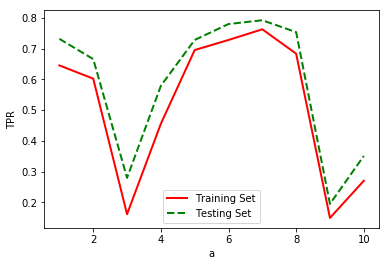

In [9]:
a=list(range(1,11))
train_tpr=[0.645111,0.602111,0.161444,0.455611,0.695167,0.727889,0.762556,0.683333,0.149333,0.270000]
test_tpr=[0.731522,0.665695,0.279560,0.578952,0.728023,0.779685,0.792017,0.753354,0.194900,0.350721]
# epochs = 100+1
# print_interval = 10
if matplotlib_is_available:
    # Plot TPR
    plt.figure()
    #x_ticks = range(int(epochs / print_interval)+1)
    plt.plot(a, train_tpr, c='r', label='Training Set', linewidth=2)
    plt.plot(a, test_tpr, c='g', linestyle='--', label='Testing Set', linewidth=2)
    #plt.xticks(x_ticks, [i*10 for i in x_ticks])
    plt.xlabel("a")
    plt.ylabel("TPR")
    plt.legend() #为每条折线添加图例
    figname = "./figures/Mirai_TPR_a.pdf"
    plt.savefig(figname)
    plt.show()

[0.8079444444444445, 0.270111, 0.271, 0.280278, 0.273722, 0.267778, 0.279222, 0.2735, 0.269667, 0.272611, 0.27]
[0.8345971169069244, 0.347888, 0.339722, 0.347054, 0.339888, 0.342055, 0.344055, 0.341305, 0.347138, 0.339138, 0.350721]


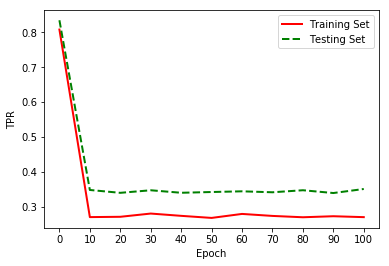

In [5]:
matplotlib_is_available = True
try:
    from matplotlib import pyplot as plt
except ImportError:
    print("Will skip plotting; matplotlib is not available.")
    matplotlib_is_available = False
Train_TPR = [0.8079444444444445,0.270111,0.271000,0.280278,0.273722,0.267778,0.279222,0.273500,0.269667,0.272611,0.270000]
Test_TPR = [0.8345971169069244,0.347888,0.339722,0.347054,0.339888,0.342055,0.344055,0.341305,0.347138,0.339138,0.350721]
print(Train_TPR)
print(Test_TPR)
epochs = 100+1
print_interval = 10
if matplotlib_is_available:
    # Plot TPR
    plt.figure()
    x_ticks = range(int(epochs / print_interval)+1)
    plt.plot(x_ticks, Train_TPR, c='r', label='Training Set', linewidth=2)
    plt.plot(x_ticks, Test_TPR, c='g', linestyle='--', label='Testing Set', linewidth=2)
    plt.xticks(x_ticks, [i*10 for i in x_ticks])
    plt.xlabel("Epoch")
    plt.ylabel("TPR")
    plt.legend() #为每条折线添加图例
    figname = "./figures/mirai_TPR.pdf"
    plt.savefig(figname)
    plt.show()


In [1]:
import torch
print(torch.cuda.is_available())

False


In [9]:
%run setup.py build_ext --inplace

Compiling AfterImage.pyx because it changed.
[1/1] Cythonizing AfterImage.pyx
running build_ext
building 'AfterImage' extension
creating build/temp.linux-x86_64-3.6
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/wzl1/anaconda3/include/python3.6m -c AfterImage.c -o build/temp.linux-x86_64-3.6/AfterImage.o
gcc -pthread -shared -L/home/wzl1/anaconda3/lib -Wl,-rpath=/home/wzl1/anaconda3/lib,--no-as-needed build/temp.linux-x86_64-3.6/AfterImage.o -L/home/wzl1/anaconda3/lib -lpython3.6m -o /home/wzl1/zy/zhuyiran/Kitsune-py/AfterImage.cpython-36m-x86_64-linux-gnu.so
